In [1]:
# Importing the libraries

import numpy as np 
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pylab as plt
from scipy import sparse
from scipy.linalg import sqrtm


In [2]:
complete_train = pd.read_csv('train.csv')
complete_train_og = complete_train.copy()
test = pd.read_csv('kaggle_baseline.csv')

## Data Processing

In [3]:
df = complete_train
def set_top_scores(group):
    # Find the highest rating
    highest_rating = group['rating'].max()
    if highest_rating == 5: # or highest_rating == 4:
        group['new_rating'] = group['rating'].apply(lambda x: 1 if x == highest_rating or x == highest_rating - 1 else 0)
    else:
        group['new_rating'] = group['rating'].apply(lambda x: 1 if x == highest_rating else 0)        
    
    return group

df = df.groupby('user_id').apply(set_top_scores).reset_index(drop=True)
df = df.drop(['rating'], axis=1)  # Remove original rating column
df.rename(columns={'new_rating': 'rating'}, inplace=True)
df = df.drop(['age', 'release_date', 'sex'], axis=1)
df

/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_21428/3661133398.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('user_id').apply(set_top_scores).reset_index(drop=True)


,user_id,title,movie_id,rating
0,1,Hercules (1997),1566,1
1,1,Erin Brockovich (2000),3408,1
2,1,Toy Story (1995),1,1
3,1,Titanic (1997),1721,1
4,1,One Flew Over the Cuckoo's Nest (1975),1193,1
...,...,...,...,...
800162,6040,"Paris, Texas (1984)",1305,1
800163,6040,Breaking Away (1979),3359,1
800164,6040,"Simple Plan, A (1998)",2391,1
800165,6040,"Haunted World of Edward D. Wood Jr., The (1995)",722,0


In [4]:
movie_title_lookup = df[['movie_id', 'title']].drop_duplicates().set_index('movie_id')['title'].to_dict()

uids = df['user_id'].unique()
mids = df['movie_id'].unique()
um_pairs = pd.DataFrame([(uid, mid) for uid in uids for mid in mids], columns=['user_id', 'movie_id'])

um_pairs = um_pairs.merge(df[['user_id', 'movie_id', 'rating']], on=['user_id', 'movie_id'], how='left')
um_pairs['title'] = um_pairs['user_id'].map(movie_title_lookup).fillna(0)
um_pairs['rating'].fillna(0, inplace=True)
um_pairs

/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_18470/1404419662.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  um_pairs['rating'].fillna(0, inplace=True)


,user_id,movie_id,rating,title
0,1,1566,1.0,Toy Story (1995)
1,1,3408,1.0,Toy Story (1995)
2,1,1,1.0,Toy Story (1995)
3,1,1721,1.0,Toy Story (1995)
4,1,1193,1.0,Toy Story (1995)
...,...,...,...,...
22227195,6040,2703,0.0,0
22227196,6040,2845,0.0,0
22227197,6040,3607,0.0,0
22227198,6040,1360,0.0,0


In [5]:
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

um_pairs['for_testing'] = False
grouped = um_pairs.groupby('user_id', group_keys=False).apply(assign_to_set)
# data_train = df[grouped.for_testing == False]
# data_test = df[grouped.for_testing == True]
data_train = um_pairs[grouped.for_testing == False]
data_test = um_pairs[grouped.for_testing == True]

/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_18470/2367173336.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = um_pairs.groupby('user_id', group_keys=False).apply(assign_to_set)


## Utility


In [6]:
def evaluate(predict_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    list_users = set(data_train.user_id)
    estimated = np.array([predict_f(u,i) if u in list_users else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def precision(recommended_items, relevant_items):
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm_top(test, recommender_object, at=25, thr_relevant = 0.85):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in tqdm(test.user_id.unique()):
        
        relevant_items = test[test.user_id==user_id]
        thr = np.quantile(relevant_items.rating,thr_relevant)
        relevant_items = np.array(relevant_items[relevant_items.rating >=thr].movie_id.values)
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.predict_top(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

## Attempt 1

In [7]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
from scipy.linalg import sqrtm

class RecSys_vanilla_mf_biases():

    def __init__(self, num_components=10):
        """ Constructor """
        self.num_components=num_components

    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict_score(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
            
                
    def fit(self,df_train,df_val, n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ Train the model. """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.train = df_train
        self.val = df_val
        
        self.urm = pd.pivot_table(df_train[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index ))
        self.users_id2index = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns )) 
        self.movies_id2index= dict(zip(self.urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.urm.columns))
        self.movie_id2title = dict(df_train.groupby(by=['movie_id','title']).count().index)
        
        
        
        self.mean_rating = self.train.rating.mean()
        
        self.ratings = np.float32(self.urm.fillna(0).values)
        self.n_users, self.n_items = self.urm.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        print(self.n_samples)
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        
        
        for epoch in range(n_epochs):
    
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(reco.predict_score,self.train,self.train))
            self.test_rmse.append(evaluate(reco.predict_score,self.train,self.val))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
            plt.plot(self.train_rmse,'--o',label="train_error")
            plt.plot(self.test_rmse,'--o',label="test_error")
            plt.legend()
            plt.show()

    def predict_score(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.mean_rating + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = self.mean_rating # this is a new movie

        return prediction
        
    def predict_top(self, user_id, at=5, remove_seen=True, return_titles = False):
        '''Given a user_id predict its top AT items'''
        seen_items = self.train[self.train.user_id==user_id].movie_id.values
        unseen_items = set(self.train.movie_id.values) - set(seen_items)
        predictions = [(item_id,self.predict_score(user_id,item_id)) for item_id in unseen_items]

        sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)[:at]
        if(return_titles):
            return [self.movie_id2title[i[0]] for i in sorted_predictions]
        return [i[0] for i in sorted_predictions]
    

## Attempt 2

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse
from scipy.linalg import sqrtm

class RecSys_vanilla_mf_biases():

    def __init__(self, num_components=10):
        """ Constructor """
        self.num_components=num_components

    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict_score(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
            
                
    def fit(self,df_train,df_val, n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ Train the model. """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.train = df_train
        self.val = df_val
        
        self.urm = pd.pivot_table(df_train[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index ))
        self.users_id2index = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns )) 
        self.movies_id2index= dict(zip(self.urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.urm.columns))
        self.movie_id2title = dict(df_train.groupby(by=['movie_id','title']).count().index)
        
        
        
        self.mean_rating = self.train.rating.mean()
        
        self.ratings = np.float32(self.urm.fillna(0).values)
        self.n_users, self.n_items = self.urm.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        print(self.n_samples)
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        
        
        for epoch in range(n_epochs):
    
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(reco.predict_score,self.train,self.train))
            self.test_rmse.append(evaluate(reco.predict_score,self.train,self.val))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
            plt.plot(self.train_rmse,'--o',label="train_error")
            plt.plot(self.test_rmse,'--o',label="test_error")
            plt.legend()
            plt.show()

    def predict_score(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.mean_rating + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = self.mean_rating # this is a new movie

        return prediction
        
    def predict_top(self, user_id, at=5, remove_seen=True, return_titles = False):
        '''Given a user_id predict its top AT items'''
        seen_items = self.train[self.train.user_id==user_id].movie_id.values
        unseen_items = set(self.train.movie_id.values) - set(seen_items)
        predictions = [(item_id,self.predict_score(user_id,item_id)) for item_id in unseen_items]

        sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)[:at]
        if(return_titles):
            return [self.movie_id2title[i[0]] for i in sorted_predictions]
        return [i[0] for i in sorted_predictions]
    

## Test Section

367755
Epoch: 0
	Train rmse: 0.5914858631068157
	Test rmse: 0.5913398139093702
Epoch: 1
	Train rmse: 0.6810607328696185
	Test rmse: 0.6809429977344651
Epoch: 2
	Train rmse: 0.7320986067241501
	Test rmse: 0.7320078799702826
Epoch: 3
	Train rmse: 0.7663134949827716
	Test rmse: 0.7662416321885491
Epoch: 4
	Train rmse: 0.7911359727914483
	Test rmse: 0.7910749837220051


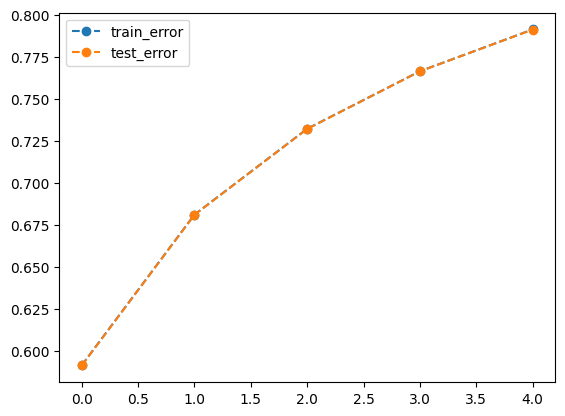

In [8]:
reco = RecSys_vanilla_mf_biases(num_components=100)
reco.fit(data_train,data_test, n_epochs = 5,learning_rate=0.02,lmbda=0.1)

In [25]:
reco.predict_top(1,return_titles = True, at=25)

['eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'Zeus and Roxanne (1997)',
 'Zeus and Roxanne (1997)',
 'eXistenZ (1999)',
 'Zeus and Roxanne (1997)',
 'Zero Kelvin (Kjærlighetens kjøtere) (1995)',
 'Zeus and Roxanne (1997)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'Zero Kelvin (Kjærlighetens kjøtere) (1995)',
 'eXistenZ (1999)',
 'Zero Effect (1998)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'eXistenZ (1999)',
 'Zeus and Roxanne (1997)']

In [26]:
evaluate_algorithm_top(data_test, reco, at = 25)

 25%|██▍       | 1502/6040 [17:45<54:47,  1.38it/s]  

Results:
- Basic Vanila+Bias-Model, basic rating, nur explicit Ratings: 0.8686 (Test RSME) + 0.0127 (MAP)
- Basic Vanila+Bias-Model, binary rating, nur explicit Ratings: 0.6377047 (Test RSME; ging bergauf haha) + 0.0007 (MAP)
- Basic Vanila+Bias-Model, binary rating, explicit&implicit Ratings: 0.8 mit aufwärtstrend (Test RSME) + 0.0007 (MAP)